# Решение задачи E2E ABSA как классфикации токенов

- Dataset - SemEval2014 - Restaurants reviews

## Considering ABSA as sequence tagging problem, use tags:

1.  1: 'TERM_POS', 2: 'TERM_NEG', 3: 'TERM_NEU', 0
В данной методике присваивания тега добавляется только тональность и задача сводиться к правильной идентификации тега через его тональность.
2. Add BIOES to tags above:
 'O': 0,
 'B_POS': 1,
 'I_POS': 2,
 'E_POS': 3,
 'B_NEG': 4,
 'I_NEG': 5,
 'E_NEG': 6,           
 'B_NEU': 7,
 'I_NEU': 8,
 'E_NEU': 9,
 'S_POS': 10,
 'S_NEU': 11,
 'S_NEG': 12   

Здесь используется объединенный тег -  для части словосочетания и тональности.

Аналогичная методика использовалась авторами статьи "Implemented by Exploiting BERT for End-to-End Aspect-based Sentiment Analysis" (https://arxiv.org/abs/1910.00883) **(2019)**. Их результат ни рис ниже (micro-averaged F1)

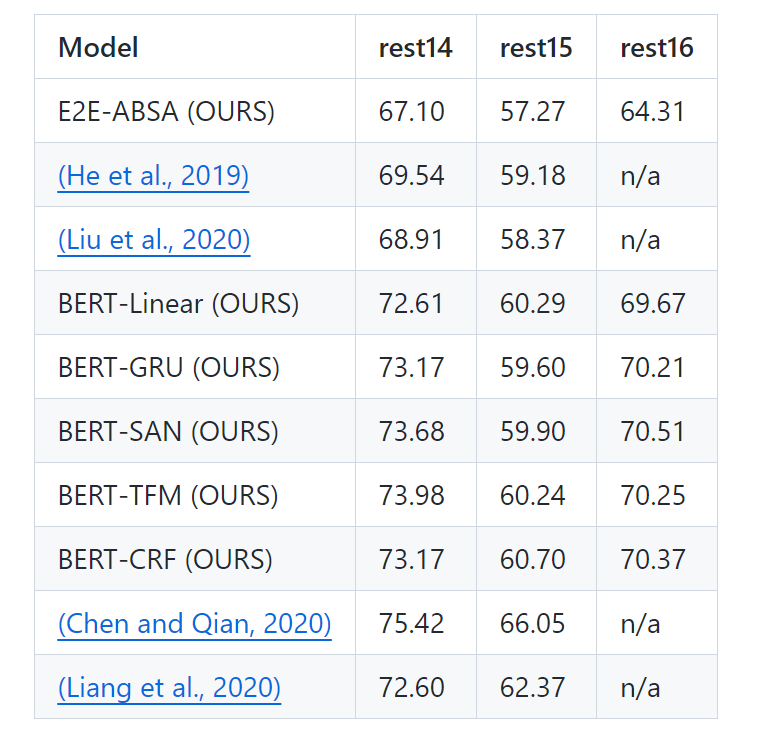

# Res14, simple tags

In [1]:
#!g2.1
%pip install -q -U einops datasets matplotlib tqdm boto3 git+https://github.com/dask/s3fs

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
#!g2.1
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!g2.1
from datasets import load_dataset
raw_datasets = load_dataset("alexcadillon/SemEval2014Task4", 'restaurants')
raw_datasets

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating trial split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories'],
        num_rows: 100
    })
    train: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories'],
        num_rows: 800
    })
})

In [4]:
#!g2.1
sample = raw_datasets['train'][10]
sample

{'sentenceId': '296',
 'text': 'They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.',
 'aspectTerms': [{'term': 'toast',
   'polarity': 'negative',
   'from': '41',
   'to': '46'},
  {'term': 'mayonnaise', 'polarity': 'negative', 'from': '18', 'to': '28'},
  {'term': 'bacon', 'polarity': 'negative', 'from': '126', 'to': '131'},
  {'term': 'cheese', 'polarity': 'neutral', 'from': '73', 'to': '79'},
  {'term': 'ingredients', 'polarity': 'negative', 'from': '57', 'to': '68'},
  {'term': 'plate', 'polarity': 'neutral', 'from': '170', 'to': '175'},
  {'term': 'omelet', 'polarity': 'neutral', 'from': '86', 'to': '92'}],
 'aspectCategories': [{'category': 'food', 'polarity': 'negative'}]}

In [5]:
#!g2.1
from nltk.tokenize import word_tokenize

In [6]:
#!g2.1
def preprocess_text(example):
    terms = []
    polarities = []
    for i in example['aspectTerms']:
        if len(word_tokenize(i['term'])) > 1:
            terms.append(word_tokenize(i['term']))
            polarities.append([i['polarity']] * len(word_tokenize(i['term'])))
        else:
            terms.append(word_tokenize(i['term']))
            polarities.append([i['polarity']])
    terms_flat = [item for sublist in terms for item in sublist]
    polarities_flat = [item for sublist in polarities for item in sublist]


    ner_tag_list = []
    for token in word_tokenize(example['text']):
        if token in terms_flat:
            if polarities_flat[terms_flat.index(token)] == 'positive':
                ner_tag_list.append(1)
            elif polarities_flat[terms_flat.index(token)] == 'negative':
                ner_tag_list.append(2)
            else:
                ner_tag_list.append(3)
        else:
            ner_tag_list.append(0)
    example['ner_tag'] = ner_tag_list
    example['tokens'] = word_tokenize(example['text'])
    
    return example

In [7]:
#!g2.1
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
#!g2.1
dataset = raw_datasets.map(
    preprocess_text,
    remove_columns = ['text', 'aspectTerms', 'aspectCategories']
)
dataset

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['sentenceId', 'ner_tag', 'tokens'],
        num_rows: 100
    })
    train: Dataset({
        features: ['sentenceId', 'ner_tag', 'tokens'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['sentenceId', 'ner_tag', 'tokens'],
        num_rows: 800
    })
})

In [9]:
#!g2.1
for token, ner_tag in zip(dataset['train'][50]['tokens'], dataset['train'][50]['ner_tag']):
    print(f'{token:_<40}{ner_tag}')

Three___________________________________0
courses_________________________________3
-_______________________________________0
choices_________________________________0
include_________________________________0
excellent_______________________________0
mussels_________________________________1
,_______________________________________0
puff____________________________________1
pastry__________________________________1
goat____________________________________1
cheese__________________________________1
and_____________________________________0
salad___________________________________1
with____________________________________1
a_______________________________________1
delicious_______________________________1
dressing________________________________1
,_______________________________________0
and_____________________________________0
a_______________________________________1
hanger__________________________________1
steak___________________________________1
au________________________________

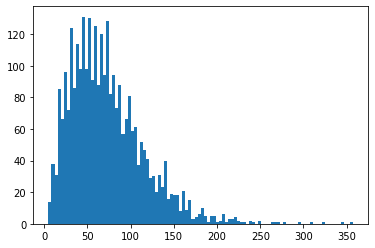

In [10]:
#!g2.1
import matplotlib.pyplot as plt
plt.hist(list(map(len, raw_datasets['train']['text'])), bins = 100);

In [11]:
#!g2.1
categories = []
for i in raw_datasets['train']['aspectCategories']:
    if i[0]['category'] not in categories:
        categories.append(i[0]['category'])
categories    

['service', 'food', 'anecdotes/miscellaneous', 'ambience', 'price']

In [12]:
#!g2.1
label2id = {'O': 0,
 'TERM_POS': 1,
 'TERM_NEG': 2,
 'TERM_NEU': 3
}

id2label={0: 'O',
 1: 'TERM_POS',
 2: 'TERM_NEG',
 3: 'TERM_NEU'
}

label_list = list(label2id.keys())

In [13]:
#!g2.1
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

In [14]:
#!g2.1
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-cased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [15]:
#!g2.1
example = dataset["train"][50]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

print(f'Token len from BERT tokenizer__{len(tokens)}')
print(f'Token len initial tokens__{len(example["tokens"])}\n')

print(' '.join(tokens))

Token len from BERT tokenizer__41
Token len initial tokens__32

[CLS] Three courses - choices include excellent m ##uss ##els , pu ##ff past ##ry goat cheese and salad with a delicious dressing , and a hang ##er steak au p ##oi ##vre that is out of this world . [SEP]


In [16]:
#!g2.1
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tag"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [17]:
#!g2.1
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True,
                               remove_columns = ['sentenceId', 'tokens', 'ner_tag'])
tokenized_dataset

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
})

In [18]:
#!g2.1
for token, label in zip(tokenizer.convert_ids_to_tokens(tokenized_dataset['train'][50]['input_ids']), 
                        tokenized_dataset['train'][50]['labels']):
    print(f'{token:_<40}{label}')

[CLS]___________________________________-100
Three___________________________________0
courses_________________________________3
-_______________________________________0
choices_________________________________0
include_________________________________0
excellent_______________________________0
m_______________________________________1
##uss___________________________________-100
##els___________________________________-100
,_______________________________________0
pu______________________________________1
##ff____________________________________-100
past____________________________________1
##ry____________________________________-100
goat____________________________________1
cheese__________________________________1
and_____________________________________0
salad___________________________________1
with____________________________________1
a_______________________________________1
delicious_______________________________1
dressing________________________________1
,__________________

Токенизация проведена, теперь у каждого токена за тсключением специальных есть тег.

In [19]:
#!g2.1
%pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

In [20]:
#!g2.1
%pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [21]:
#!g2.1
import evaluate

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

2023-11-25 18:02:55.119611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
#!g2.1
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [23]:
#!g2.1
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

In [24]:
#!g2.1
%pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

In [25]:
#!g2.1
model = AutoModelForTokenClassification.from_pretrained(
    "bert-large-cased", num_labels=4, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="token_class_model",
    learning_rate=5e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    push_to_hub=False,
    save_strategy="no", 
    group_by_length=True,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.168043,0.604781,0.666374,0.634085,0.943511
2,0.208200,0.123941,0.692174,0.698859,0.695500,0.953969
3,0.074100,0.128810,0.711750,0.739245,0.725237,0.957614
4,0.031400,0.170655,0.753982,0.748025,0.750992,0.961733
5,0.031400,0.176869,0.743745,0.756804,0.750218,0.961971
6,0.007500,0.182941,0.748052,0.758560,0.753269,0.962288


TrainOutput(global_step=2286, training_loss=0.07072809268170455, metrics={'train_runtime': 180.3735, 'train_samples_per_second': 101.157, 'train_steps_per_second': 12.674, 'total_flos': 678022373868336.0, 'train_loss': 0.07072809268170455, 'epoch': 6.0})

# Выводы:
Если говорить о классификации токенов, то результаты получились неплохая, но в задаче ABSA важна точность нахождения аспекта. Поэтому проверим, какое кол-во от нужных аспектов удалось найти модели. Здесь будем считать не все токены, а только те, которые содержат аспект

In [26]:
#!g2.1
res = trainer.predict(tokenized_dataset['test'])

predictions = res.predictions
labels = res.label_ids
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]


count_total = 0
count_matches = 0

for label, prediction in zip(true_labels, true_predictions):
    if label != 'O':
        count_total += 1
        if label == prediction:
            count_matches += 1
print(f'Accuracy on E2E ABSA: {count_matches/count_total}')

Accuracy on E2E ABSA: 0.7125


# Вывод:
Данный показатель уже можно сравнивать с бенчмарками по задаче и представляет он собой ничто иное как точность экстракции аспекта (accuracy)

# BIOES + polarity

Добавим в тег эелементы BIOES, чтобы была сохранена последовательность слов в случае, если аспект больше одного слова. В остальном методика такая же, как и в предыдущем варианте. 


In [27]:
#!g2.1
def preprocess_text2(example):
    terms = []
    polarities = []
    for i in example['aspectTerms']:
        terms.append(i['term'])
        polarities.append(i['polarity'])

    ner_tag = []
    tokens = []
    for term in terms:
        if len(term.split(' '))> 1:
            if polarities[terms.index(term)] == 'positive':
                token_list = term.split(' ')
                for ind, tok in enumerate(token_list):
                    if ind == 0:
                        ner_tag.append(1)
                        tokens.append(tok)
                    elif ind == len(token_list)-1:
                        ner_tag.append(3)
                        tokens.append(tok)
                    else:
                        ner_tag.append(2)
                        tokens.append(tok)
            elif polarities[terms.index(term)] == 'negative':
                token_list = term.split(' ')
                for ind, tok in enumerate(token_list):
                    if ind == 0:
                        ner_tag.append(4)
                        tokens.append(tok)
                    elif ind == len(token_list)-1:
                        ner_tag.append(6)
                        tokens.append(tok)
                    else:
                        ner_tag.append(5)
                        tokens.append(tok)
            else:
                token_list = term.split(' ')
                for ind, tok in enumerate(token_list):
                    if ind == 0:
                        ner_tag.append(7)
                        tokens.append(tok)
                    elif ind == len(token_list)-1:
                        ner_tag.append(9)
                        tokens.append(tok)
                    else:
                        ner_tag.append(8)
                        tokens.append(tok)


        else:
            if polarities[terms.index(term)] == 'positive':
                ner_tag.append(10)
                tokens.append(term)
            elif polarities[terms.index(term)] == 'negative':
                ner_tag.append(12)
                tokens.append(term)
            else:
                ner_tag.append(11)
                tokens.append(term)

    ner_tag_list_fin = []
    tokens_fin = []
    for token in word_tokenize(example['text']):
        if token in tokens:
            ner_tag_list_fin.append(ner_tag[tokens.index(token)])
            tokens_fin.append(token)
            ner_tag.pop(tokens.index(token))
            tokens.pop(tokens.index(token))
        else:
            ner_tag_list_fin.append(0)
            tokens_fin.append(token)

    example['ner_tag'] = ner_tag_list_fin
    example['tokens'] = tokens_fin
    
    return example

In [28]:
#!g2.1
label2id = {'O': 0,
 'B_POS': 1,
 'I_POS': 2,
 'E_POS': 3,
 'B_NEG': 4,
 'I_NEG': 5,
 'E_NEG': 6,           
 'B_NEU': 7,
 'I_NEU': 8,
 'E_NEU': 9,
 'S_POS': 10,
 'S_NEU': 11,
 'S_NEG': 12            
            
}

id2label={0: 'O',
 1: 'B_POS',
 2: 'I_POS',
 3: 'E_POS',
 4: 'B_NEG',
 5: 'I_NEG',
 6: 'E_NEG',        
 7: 'B_NEU',
 8: 'I_NEU',
 9: 'E_NEU',         
 10: 'S_POS',
 11: 'S_NEU',
 12: 'S_NEU',         
          
}

label_list = list(label2id.keys())

In [29]:
#!g2.1
dataset = raw_datasets.map(
    preprocess_text2,
    remove_columns = ['text', 'aspectTerms', 'aspectCategories']
)
dataset

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['sentenceId', 'ner_tag', 'tokens'],
        num_rows: 100
    })
    train: Dataset({
        features: ['sentenceId', 'ner_tag', 'tokens'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['sentenceId', 'ner_tag', 'tokens'],
        num_rows: 800
    })
})

In [30]:
#!g2.1
for token, ner_tag in zip(dataset['train'][50]['tokens'], dataset['train'][50]['ner_tag']):
    print(f'{token:_<40}{ner_tag}')

Three___________________________________0
courses_________________________________11
-_______________________________________0
choices_________________________________0
include_________________________________0
excellent_______________________________0
mussels_________________________________10
,_______________________________________0
puff____________________________________1
pastry__________________________________2
goat____________________________________2
cheese__________________________________3
and_____________________________________0
salad___________________________________1
with____________________________________2
a_______________________________________2
delicious_______________________________2
dressing________________________________3
,_______________________________________0
and_____________________________________0
a_______________________________________0
hanger__________________________________1
steak___________________________________2
au______________________________

In [31]:
#!g2.1
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True,
                               remove_columns = ['sentenceId', 'tokens', 'ner_tag'])
tokenized_dataset

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
})

In [32]:
#!g2.1
for token, label in zip(tokenizer.convert_ids_to_tokens(tokenized_dataset['train'][50]['input_ids']), 
                        tokenized_dataset['train'][50]['labels']):
    print(f'{token:_<40}{label}')

[CLS]___________________________________-100
Three___________________________________0
courses_________________________________11
-_______________________________________0
choices_________________________________0
include_________________________________0
excellent_______________________________0
m_______________________________________10
##uss___________________________________-100
##els___________________________________-100
,_______________________________________0
pu______________________________________1
##ff____________________________________-100
past____________________________________2
##ry____________________________________-100
goat____________________________________2
cheese__________________________________3
and_____________________________________0
salad___________________________________1
with____________________________________2
a_______________________________________2
delicious_______________________________2
dressing________________________________3
,________________

In [33]:
#!g2.1
model = AutoModelForTokenClassification.from_pretrained(
    "bert-large-cased", num_labels=13, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="token_class_model",
    learning_rate=5e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    push_to_hub=False,
    save_strategy="no", 
    group_by_length=True,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.173158,0.613846,0.696335,0.652494,0.943274
2,0.316900,0.148407,0.661450,0.700698,0.680508,0.950563
3,0.092400,0.166503,0.722417,0.719895,0.721154,0.954841
4,0.040500,0.156320,0.745234,0.750436,0.747826,0.959515
5,0.040500,0.173775,0.738723,0.757417,0.747953,0.959990
6,0.012300,0.177848,0.738908,0.755672,0.747196,0.960387


TrainOutput(global_step=2286, training_loss=0.10167095531837417, metrics={'train_runtime': 180.744, 'train_samples_per_second': 100.949, 'train_steps_per_second': 12.648, 'total_flos': 678043063366236.0, 'train_loss': 0.10167095531837417, 'epoch': 6.0})

In [34]:
#!g2.1
res = trainer.predict(tokenized_dataset['test'])

predictions = res.predictions
labels = res.label_ids
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]


count_total = 0
count_matches = 0

for label, prediction in zip(true_labels, true_predictions):
    if label != 'O':
        count_total += 1
        if label == prediction:
            count_matches += 1
print(f'Accuracy on E2E ABSA: {count_matches/count_total}')

Accuracy on E2E ABSA: 0.69625


In [35]:
#!g2.1
for label, prediction in zip(true_labels, true_predictions):
    print(label)
    print(prediction)
    print('================================')

['O', 'S_POS', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'S_POS', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_POS', 'E_POS', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_POS', 'E_POS', 'O', 'O', 'O', 'O']
['S_POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['S_POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'S_POS', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'S_POS', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'S_NEU', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S_POS', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'S_NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S_POS', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'S_POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'S_POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_POS', 'E_POS', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_POS', 'E_POS', 'O']
['O', 

# Вывод финальный

Добавлние элементов BIOES не особо повлияло на результативность модели, особого прироста как в классификации токенов, так и в целом точности извлечения аспктов не получилось. 